# Statistical Rethinking: Chapter 4 Practice Answers

We use some of the code from [the pymc-devs Python/pymc3 port of the Statistical Rethinking code examples](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/).

### 4E1

Line 1: $y_i \sim \text{Normal}(\mu,\sigma)$

### 4E2

Two parameters are in the posterior: $\mu$ and $\sigma$.

### 4E3

We can express our posterior joint distribution over $\mu$ and $\sigma$ as:

$$P(\mu,\sigma|\mathbf{y}) = \frac{\prod_i\text{Normal}(y_i|\mu,\sigma)\text{Normal}(\mu|0,10)\text{Exponential}(\sigma|1)}{\int\int\prod_i\text{Normal}(y_i|\mu,\sigma)\text{Normal}(\mu|0,10)\text{Exponential}(\sigma|1)d\mu d\sigma}$$



### 4E4

Line 2: $\mu_i = \alpha + \beta x_i$

### 4E5

Three parameters are in the posterior: $\alpha$, $\beta$, and $\sigma$.

### 4M1



In [16]:
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats

Text(0.5, 0, 'y')

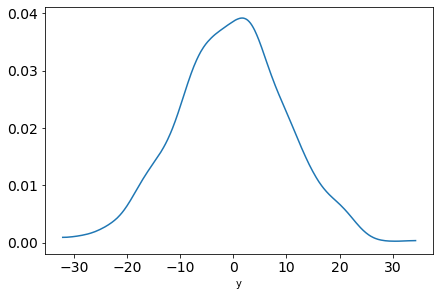

In [18]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=0, scale=10, size=n_samples)
sample_sigma = stats.expon.rvs(1, size=n_samples)
prior_y = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_y)
plt.xlabel("y")

### 4M2

The point of my Python/pymc3 solutions is to learn pymc3, so instead of using quadratic approximation, which I'll likely never do in practice, we'll use HMC.

In [26]:
import pymc3 as pm

with pm.Model() as model_4m2:
    mu = pm.Normal("mu", mu=0, sd=10)
    sigma = pm.Exponential("sigma", lam=1)
    y = pm.Normal("y", mu=mu, sd=sigma)

array([[<AxesSubplot:title={'center':'sigma_log__'}>,
        <AxesSubplot:title={'center':'sigma_log__'}>],
       [<AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

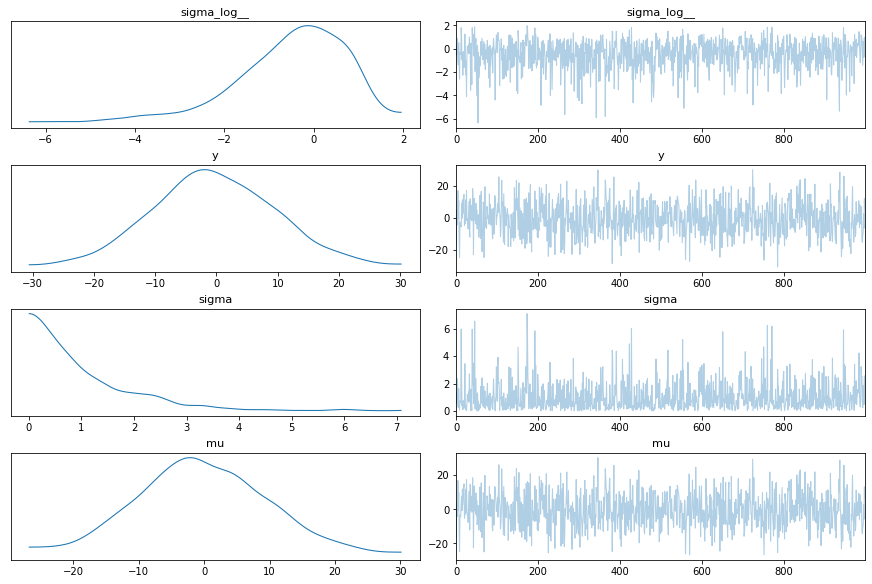

In [27]:
# Do some prior checks to confirm our model is similar to the one above.
with model_4m2:
    prior_checks = pm.sample_prior_predictive(samples=1000)
az.plot_trace(prior_checks)

### 4M3

$$y_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu = \alpha + \beta x$$
$$\alpha \sim \text{Normal}(0, 10)$$
$$\beta \sim \text{Uniform}(0, 1)$$
$$\sigma \sim \text{Exponential}(1)$$

### 4M4

Average age of a growing student is probably around 12 years old. Average heights online are around 150cm for these.

$$h_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu = \alpha + \beta (t_i - \bar{t})$$
$$\alpha \sim \text{Normal}(150, 20)$$
$$\beta \sim \text{Uniform}(0, 10)$$
$$\sigma \sim \text{Exponential}(1)$$

### 4M5

In one sense I've already accounted for this by setting my mean for $\alpha$ to be that height of a child, rather than that of an adult.

However, we want the slopes to be positive. Let's check our prior predictive distribution to be sure.

In [91]:
import numpy as np
t = np.array([1,2,3])
with pm.Model() as model_4m5:
    alpha = pm.Normal("alpha", mu=150, sd=20)
    beta = pm.Uniform("beta", 0, 10)
    sigma = pm.Exponential("sigma", lam=1)
    mu = alpha + beta*(t-t.mean())
    y = pm.Normal("y", mu=mu, sd=sigma, observed=[1,2,3])

In [95]:
with model_4m5:
    prior_checks = pm.sample_prior_predictive(samples=50)

Text(0, 0.5, 'Mean Outcome (stdz)')

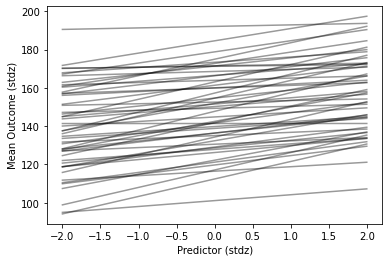

In [96]:
_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["alpha"], prior_checks["beta"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")

Yes, all those slops look non-negative.

### 4M6

In this case we'd want to bound $\sigma$ to be no more than 8 (since variance of 64 means a standard deviation of 8). The question is what the best way to bound this variable is.

Honestly, the probability mass is so low at sigma=8 that I wouldn't worry setting a hard boundary.

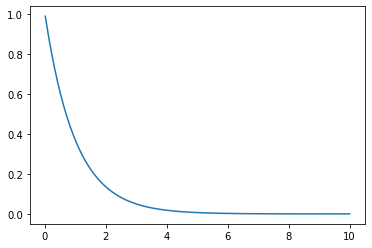

In [133]:
x = np.linspace(0.01,10, num=100)
plt.plot(x, stats.expon.pdf(x))

### 4M7

In [138]:
import pandas as pd

d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]

In [186]:
xbar = d2.weight.mean()
with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (d2.weight)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.8973791599068629, but should be close to 0.8. Try to increase the number of tuning steps.


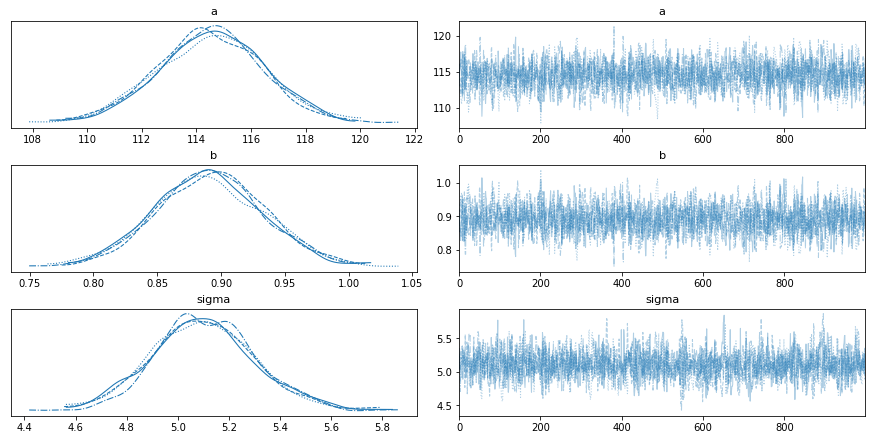

In [236]:
with m4_3:
    trace = pm.sample(1000, tune=2000)
    az.plot_trace(trace)

In [205]:
with m4_3:
    prior_checks = pm.sample_prior_predictive(samples=50)

In [216]:
with m4_3:
    posterior_checks = pm.sample_posterior_predictive(trace, var_names=["a", "b", "height"])

Text(0, 0.5, 'Mean Outcome (stdz)')

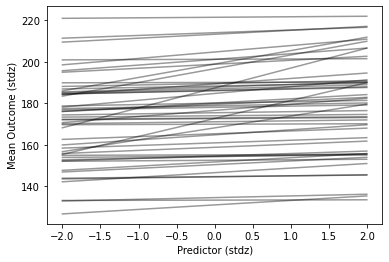

In [240]:
_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["a"], prior_checks["b"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


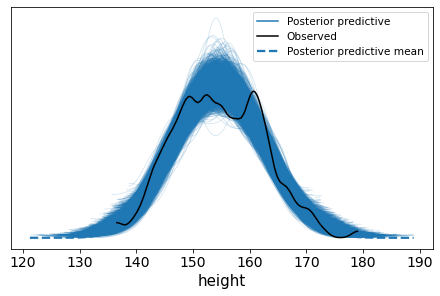

In [214]:
az.plot_ppc(az.from_pymc3(posterior_predictive=posterior_checks, model=m4_3));

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


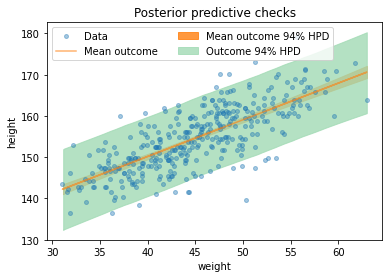

In [237]:
mu_pp = (posterior_checks["a"] + posterior_checks["b"] * d2.weight.values[:, None]).T

_, ax = plt.subplots()

ax.plot(d2.weight, d2.height, "o", ms=4, alpha=0.4, label="Data")
ax.plot(d2.weight, mu_pp.mean(0), label="Mean outcome", alpha=0.6)
az.plot_hdi(
    d2.weight,
    mu_pp,
    ax=ax,
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
)
az.plot_hdi(
    d2.weight,
    ppc["height"],
    ax=ax,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Outcome 94% HPD"},
)

ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.set_title("Posterior predictive checks")
ax.legend(ncol=2, fontsize=10);

In [235]:
az.summary(trace, kind="stats")

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,114.616,1.884,110.790,117.946
b,0.889,0.041,0.806,0.962
sigma,5.100,0.195,4.748,5.470


The $\alpha$ variable no longer is the mean, since $\beta$ is not multiplied by 0 when the input weight is the mean. Instead, $\alpha$ is lower.

In [191]:
xbar

44.99048551988636

In [192]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.cov()

,a,b,sigma
a,3.608567,-0.078704,-0.002686
b,-0.078704,0.001752,0.000082
sigma,-0.002686,0.000082,0.039086


Seems to induce some minor covariance between $\alpha$ and $\beta$

The posterior predictions of the models are the same. Show this.

### 4M8

In [244]:
d = pd.read_csv("data/cherry_blossoms.csv")
# nans are not treated as in the book
az.summary(d.dropna().to_dict(orient="list"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
year,1533.395,291.123,1016.00,1978.00
doy,104.921,6.258,92.00,115.00
temp,6.100,0.683,4.80,7.32
temp_upper,6.938,0.812,5.56,8.40
temp_lower,5.264,0.762,3.75,6.83


In [260]:
d2 = d.dropna(subset=["doy"])
num_knots = 30
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

In [261]:
from patsy import dmatrix

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)

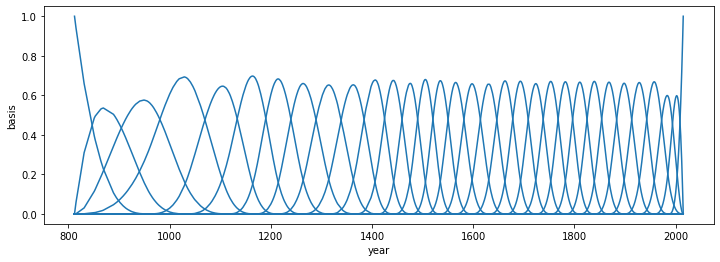

In [262]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(num_knots+2):
    ax.plot(d2.year, (B[:, i]), color="C0")
ax.set_xlabel("year")
ax.set_ylabel("basis");

In [273]:
with pm.Model() as m4_7:
    a = pm.Normal("a", 100, 1)
    w = pm.Normal("w", mu=0, sd=1, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    # mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d2.doy)
    trace_m4_7 = pm.sample(1000)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [266]:
#15 knots

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


Text(0, 0.5, 'days in year')

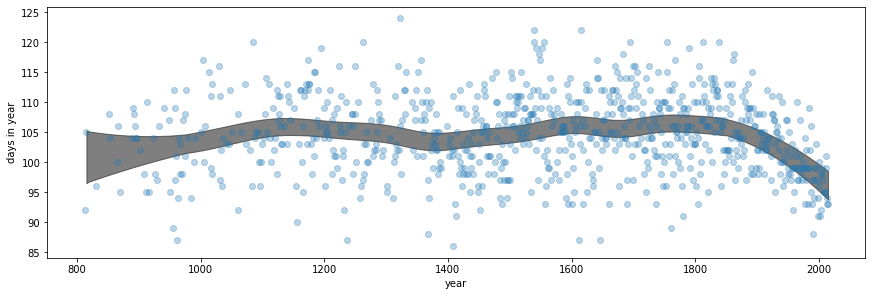

In [251]:
ax = az.plot_hdi(d2.year, trace_m4_7["mu"], color="k")
ax.plot(d2.year, d2.doy, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")


In [267]:
# 30 knots

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


Text(0, 0.5, 'days in year')

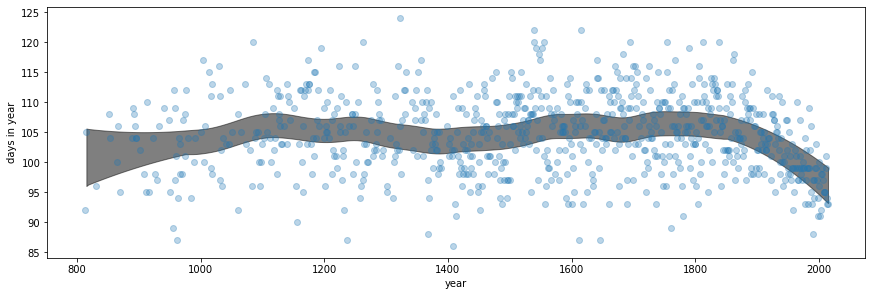

In [264]:
ax = az.plot_hdi(d2.year, trace_m4_7["mu"], color="k")
ax.plot(d2.year, d2.doy, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")

In [269]:
# 30 knots with a wider prior

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


Text(0, 0.5, 'days in year')

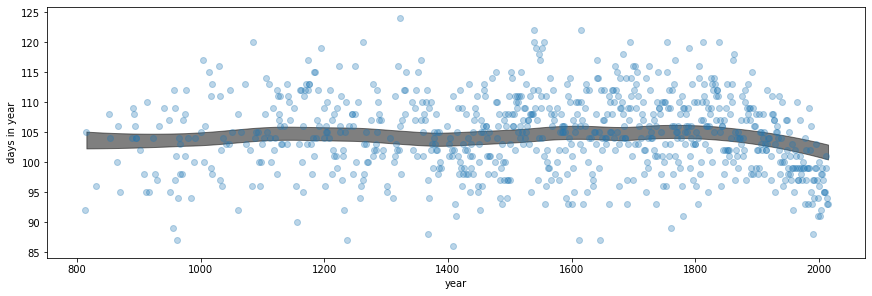

In [274]:
ax = az.plot_hdi(d2.year, trace_m4_7["mu"], color="k")
ax.plot(d2.year, d2.doy, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")

Having more knots gives the spline more room to try and fit the data more closely and possibly overfit. Making the prior more narrow counteracts this.